In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats

%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/data'


In [9]:
def calc_kd(z,par):
    z = np.abs(z)
    # remove nans and negative par values (bad data)
    z = z[(par>=0) & ~np.isnan(par)]
    par = par[(par>=0) & ~np.isnan(par)]

    # calculate Kd from the log-linear slope of the light decay
    lnpar = np.log(par)
    
    fit = stats.linregress(x=z,y=lnpar)
    kd = np.abs(fit.slope)
    rval = np.abs(fit.rvalue)
    stderr = fit.stderr
    return kd, rval, stderr


def ooi_run_kdcalc(df):
    
    # get the start time of the file
    t = df.loc[0,'time'] 
    # check if there is no data shallower than 20 m:
    df = df[abs(df['z'])<20]
    if len(df) < 4:
        kd = np.nan
        rval = np.nan
        stderr = np.nan
        return kd, rval, stderr, t
        
    # if there is data, check for multiple casts:
    df.reset_index(drop=True, inplace=True)
    dt = df['time'].diff()
    df['cast'] = 0
    cast = 0
    for jj in range(len(df)):
        if dt[jj]>timedelta(minutes=10):
            cast += 1
            df.loc[jj,'cast'] = cast
        else:
            df.loc[jj,'cast'] = cast
    tot_casts = len(np.unique(df['cast']))
    
    # if there's only 1 cast, calculate kd once
    # otherwise loop through casts and calc for each
    if tot_casts==1:
        # pull out depth and par
        z = df['z'].to_numpy()
        par = df['par'].to_numpy()
        t = df.loc[0,'time']
        kd, rval, stderr = calc_kd(z,par)
    else:
        kd = np.empty(tot_casts)
        rval = np.empty(tot_casts)
        stderr = np.empty(tot_casts)
        t = df.loc[:tot_casts,'time']
        for jj in range(tot_casts):
            z = df.loc[df['cast']==jj,'z'].to_numpy()
            par = df.loc[df['cast']==jj,'par'].to_numpy()
            t[jj] = min(df.loc[df['cast']==jj,'time'])
            kd[jj], rval[jj], stderr[jj] = calc_kd(z,par)
            
    return kd, rval, stderr, t





# much simpler for ws dataset - only 1 cast per file
def ws_kd_calc(df):
    # pull out depth and par
    z = np.abs(df['z'].to_numpy())
    par = df['par'].to_numpy()
  
    # remove nans and negative par values (bad data)
    z = z[(par>=0) & ~np.isnan(par)]
    par = par[(par>=0) & ~np.isnan(par)]

    # only calculate over upper 10m
    par = par[z<20]
    z = z[z<20]
    
    if len(z) == 0:
        kd = np.nan
        rval = np.nan
        stderr = np.nan
    else:
        # calc ln of par 
        lnpar = np.log(par)
        # calculate Kd from the log-linear slope of the light decay
        fit = stats.linregress(x=z,y=lnpar)
#         par_pred = fit.slope*z + lnpar[0]
        kd = np.abs(fit.slope)
        rval = fit.rvalue
        stderr=fit.stderr

    return kd,rval,stderr

1.0010991938234688 -0.9986642388432644
1.0040070941250372 -0.9751482427953707


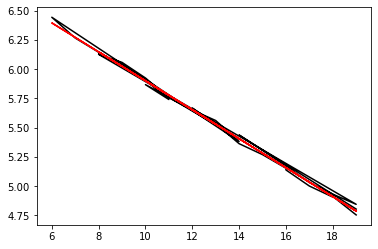

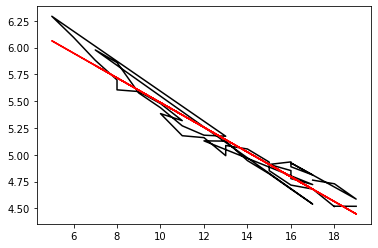

In [77]:
FF = glob.glob('icesat2/ooi/data*.csv')
FF.sort()

ooi_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)),
                            columns=['time','lat','lon','kd','rval','stderr','stn']
                           )
jj = 43
    
df = pd.read_csv(FF[jj],
                 index_col=0,
                 header=0,
                 usecols=[i for i in range(6)],
                 names=['', 'time', 'lat', 'lon', 'z', 'par']
                ) #
df['time'] = pd.to_datetime(df["time"]).round('s')
df = df[abs(df['z'])<20]
df.reset_index(drop=True, inplace=True)
dt = df['time'].diff()

df['cast'] = 0
cast = 0
for jj in range(len(df)):
    if dt[jj]>timedelta(minutes=10):
        cast += 1
        df.loc[jj,'cast'] = cast
    else:
        df.loc[jj,'cast'] = cast
tot_casts = len(np.unique(df['cast']))


for jj in range(tot_casts):
    # pull out depth and par
    z = np.abs(df.loc[df['cast']==jj,'z'].to_numpy())
    par = df.loc[df['cast']==jj,'par'].to_numpy()
    
#     # sort by depth
#     par = par[np.argsort(z)]
#     z = np.sort(z)

    # remove nans and negative par values (bad data)
    z = z[(par>=0) & ~np.isnan(par)]
    par = par[(par>=0) & ~np.isnan(par)]
    
    lnpar = np.log(par)
    # calculate Kd from the log-linear slope of the light decay
    fit = stats.linregress(x=z,y=lnpar)
    kd = np.abs(fit.slope)
    rval = np.abs(fit.rvalue)
    stderr = fit.stderr
    print(stderr,rval)

#     plt.figure()
#     plt.plot(z,lnpar,'k-')
#     par_pred = fit.slope*z +fit.intercept
#     plt.plot(z,par_pred,'r-')



In [18]:
# calculate Kd from OOI data


FF = glob.glob('icesat2/ooi/data*.csv')
FF.sort()

ooi_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)*2),
                            columns=['time','lat','lon','kd','rval','stderr']
                           )
cc = 0
for fname in FF:
    # load the file as a pandas array
    df = pd.read_csv(fname,
                     index_col=0,
                     header=0,
                     usecols=[i for i in range(6)],
                     names=['', 'time', 'lat', 'lon', 'z', 'par']
                    ) #
    df['time'] = pd.to_datetime(df["time"]).round('s')
    # ooi_kd_array.loc[jj,'stn'] = FF[jj][9:-4] # save the file name if its useful

    # calculate kd (there may be more than 1 value if there are multiple casts in 1 file)
    try:
        kd,rval,stderr,t = ooi_run_kdcalc(df)
    except:
        kd = np.nan
        rval = np.nan
        stderr = np.nan
    
    # either put in the 1 value or put in each value...super dumb way to do this but Im in a rush
    if type(kd) != np.ndarray:
        ooi_kd_array.loc[cc,'time'] = t
        ooi_kd_array.loc[cc,'lat'] = df.loc[1,'lat']
        ooi_kd_array.loc[cc,'lon'] = df.loc[1,'lon']
        ooi_kd_array.loc[cc,'kd'] = kd
        ooi_kd_array.loc[cc,'rval'] = rval
        ooi_kd_array.loc[cc,'stderr'] = stderr
        cc += 1 # raise counter
    else: 
        for jj in range(len(kd)):
            ooi_kd_array.loc[cc,'time'] = t[jj]
            ooi_kd_array.loc[cc,'lat'] = df.loc[1,'lat']
            ooi_kd_array.loc[cc,'lon'] = df.loc[1,'lon']
            ooi_kd_array.loc[cc,'kd'] = kd[jj]
            ooi_kd_array.loc[cc,'rval'] = rval[jj]
            ooi_kd_array.loc[cc,'stderr'] = stderr[jj]
            cc += 1 # raise counter

ooi_kd_array = ooi_kd_array.dropna(how='all')

# pd.DataFrame()
# d = {'time' = ff[0,1],'kd': m, 'rval': rval, 'stderr': stderr}
# df = pd.DataFrame(data=d)

ooi_kd_array.to_csv('../output/icesat2/ooi_kdcalculations10m.csv')
ooi_kd_array

/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_82733/2592737949.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = 0
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_82733/2592737949.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'] = 0
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_82733/2592737949.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,time,lat,lon,kd,rval,stderr
0,2019-06-03 13:59:00+00:00,44.6589,-124.09595,0.200945,0.997587,0.003611
1,2019-08-06 19:59:00+00:00,44.6589,-124.09595,0.395541,0.98714,0.015536
2,2021-08-28 20:06:00+00:00,44.6589,-124.09595,0.21767,0.994769,0.005421
3,2022-07-02 20:07:00+00:00,44.6589,-124.09595,0.443859,0.985796,0.017824
4,2019-10-07 20:16:00+00:00,44.63302,-124.30233,0.218362,0.999622,0.001416
5,2023-05-30 12:03:00+00:00,44.369353,-124.954108,NaN,NaN,NaN
6,2024-08-26 14:35:00+00:00,44.369353,-124.954108,0.114253,0.985469,0.003282
7,2024-08-26 16:50:00+00:00,44.369353,-124.954108,0.095343,0.989141,0.002361
8,2024-08-26 19:15:00+00:00,44.369353,-124.954108,0.096678,0.998941,0.000775
9,2019-09-08 20:03:00+00:00,47.13553,-124.27017,0.262604,0.997522,0.004492


In [20]:
# calculate kd for all of gulf of mexico ctd profiles 
FF = glob.glob('icesat2/ctd_ws/data*.csv')
FF.sort()

ws_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)),
                            columns=['time','lat','lon','kd','rval','stderr']
                           )

for jj in range(len(FF)):
    df = pd.read_csv(FF[jj],
                     index_col=0,
                     header=0,
                     usecols=[i for i in [0,2,3,4,5,6,28]],
                     names=['','prof', 'time', 'lat', 'lon', 'z', 'par']
                    )
#     ws_kd_array.loc[jj,'stn'] = FF[jj][12:-4]
    
    try:
        kd,rval,stderr = ws_kd_calc(df)
    except:
        kd = np.nan
        rval = np.nan
        stderr = np.nan

    time = df.loc[1,'time']
    lat = df.loc[1,'lat']
    lon = df.loc[1,'lon']

    ws_kd_array.loc[jj,'time'] = time
    ws_kd_array.loc[jj,'lat'] = lat
    ws_kd_array.loc[jj,'lon'] = lon
    ws_kd_array.loc[jj,'kd'] = kd
    ws_kd_array.loc[jj,'rval'] = rval
    ws_kd_array.loc[jj,'stderr'] = stderr



pname = '../output/icesat2/'
ws_kd_array.to_csv(pname+'ws_kdcalculations10m.csv')
ws_kd_array

,time,lat,lon,kd,rval,stderr
0,2018-12-18T08:19:41Z,24.597167,-81.181333,0.204801,-0.91141,0.002248
1,2020-08-20T00:54:19Z,25.404333,-82.2105,0.000078,-0.00374,0.000411
2,2020-10-09T09:36:26Z,26.632167,-82.5595,1.567188,-0.797945,0.023695
3,2022-12-06T19:31:24Z,27.796667,-82.879667,0.001969,0.532738,0.00006
4,2022-12-06T20:09:35Z,27.7405,-82.928333,0.000124,0.130719,0.000017


In [4]:
# Process BCODMO data : only keep unique entries to search ICESat-2
FF = glob.glob('bcodmo/*.csv')
FF.sort()

for jj in range(len(FF)):
    df = pd.read_csv(FF[jj],header=0)
    df.drop(0,inplace=True)
    df = df.drop_duplicates(subset=['time'])
    df.reset_index(drop=True, inplace=True)

    print(FF[jj])
    print(df.head())
    
    fname = FF[jj][:-4]+'_unique.pkl'
    df.to_pickle(fname)



bcodmo/bcodmo_dataset_518582_2e2e_e9a0_6c3e.csv
  cast latitude  longitude depth_w                  time     par
0   01   21.391  -158.2908    1323  2013-07-02T04:14:31Z  383.36
1   01    22.75  -158.0002    4743  2013-07-02T21:55:50Z  3588.1
2   02    22.75  -158.0003    4742  2013-07-03T13:53:21Z  2.2892
3   01  24.0882   -157.999    4496  2013-07-03T21:56:40Z  1001.3
4   01  27.0658  -157.9975    5392  2013-07-04T13:59:16Z  1.9284
bcodmo/bcodmo_dataset_757784_f8fc_ca99_ecce.csv
  Station       Site                  time depth     Par  latitude  longitude
0     001  Shakedown  2018-05-07T17:46:00Z   3.0  1460.0  11.24758  -56.32338
1     001  Shakedown  2018-05-07T17:47:00Z   7.0   169.0  11.24768  -56.32336
2     001  Shakedown  2018-05-07T17:48:00Z  30.0    45.1  11.24788  -56.32324
3     001  Shakedown  2018-05-07T17:49:00Z  56.0    14.8  11.24816  -56.32307
4     001  Shakedown  2018-05-07T17:50:00Z  85.0    3.71  11.24842  -56.32296
bcodmo/bcodmo_dataset_774958_89bb_d996_f2f0.cs

In [20]:
# Process BCODMO data
FF = glob.glob('bcodmo/*.csv')
FF.sort()

# ws_kd_array = pd.DataFrame(data=None,
#                             index=range(len(FF)),
#                             columns=['time','lat','lon','kd','rval','stderr','stn']
#                            )
jj = 1

df = pd.read_csv(FF[jj],
                 header=0)
df = df.drop_duplicates(subset=['time'])
df.head()

,Station,Site,time,depth,Par,latitude,longitude
0,unitless,unitless,UTC,m,micromoles photons per square meter per second...,degrees_north,degrees_east
1,001,Shakedown,2018-05-07T17:46:00Z,3.0,1460.0,11.24758,-56.32338
5,001,Shakedown,2018-05-07T17:47:00Z,7.0,169.0,11.24768,-56.32336
28,001,Shakedown,2018-05-07T17:48:00Z,30.0,45.1,11.24788,-56.32324
54,001,Shakedown,2018-05-07T17:49:00Z,56.0,14.8,11.24816,-56.32307
